In [1]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [2]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm

In [3]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 1000

# Number of iteration stop criterion
it_max = 10

# Initialization of the number of iteration
it = 1

# The number of solutions that we will have in the solver after the first iteration
k_k = 10

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

In [4]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver = fm.initialize_solver(data, n, m, duration)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k, n, m, 0, T_machine, optimalval)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model
variables = solver.get_variables()

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, variables, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model variables created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 2328396
Le max de list_obj est 3665846
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x000002C0DB6D15C0>, <docplex.cp.solution.CpoSolveResult object at 0x000002C0D23BAAC0>], [<docplex.cp.solution.CpoSolveResult object at 0x000002C0E0FEDBC0>, <docplex.cp.solution.CpoSolveResult object at 0x000002C0DECF51

In [5]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))
    it += 1

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # --------- Add the constraints considering the clustering
    
        #------------------ Layers creation 
    # layers = cl.create_layers(list_equal, matrix)
    layers = cl.create_layers_fixed(list_layers)
    print(len(layers))
    # print(len(layers[i]) for i in range (len(layers)))
        #------------------ Définition du nombre de clusters par layer (liste des nb de clusters par layer)
    nb_clusters = fm.choose_best_clusters(layers)

    default_value_rayon = 5 

    for l in range(len(layers)):
        data = layers[l]
        k = nb_clusters[l]

        print("-------------- Layer", l, "-----------------")
        print("Number of clusters :", k)
        print("Number of solutions :", len(data))

        if l > 0:
            #------------------ If there is only one solution in the layer, we add a constraint to the model
            if(len(data)==0):
                continue
            elif (len(data) == 1):
                solver.add_constraint(model, fm.manhattan_distance(data[0], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > default_value_rayon + l)
                continue
            else :
            #------------------ Get the average of each cluster
                k, avg, labels = fm.average_computation(data, k)

            #------------------ Get the solutions which is the closest to the average of each cluster
                the_ones = fm.solution_average(k, data, labels, avg)
                
            #------------------ Ajout de contraintes, les solutions doivent etre distantes des centres de clusters, en chaque layer , d'une distance supérieure au rayon du cluster + l
                #------------------ Liste des solutions des clusters de la layer l

                for i in range(k):
                    sol_cluster=[]
                    for j in range(len(data)):
                        if labels[j]==i:
                            sol_cluster.append(data[j])
                #------------------ Ajout des contraintes
                    solver.add_constraint(model, fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >  fm.rayon_cluster(the_ones[i], sol_cluster) + l)
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, variables, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max)
    fm.stopCondition(it, it_max, tps, tps_max)


--------Iteration 1---------

Creating the model variables...
Model variables created !

Solver initialized !
Clustering ...
5
-------------- Layer 0 -----------------
Number of clusters : 2
Number of solutions : 2
-------------- Layer 1 -----------------
Number of clusters : 2
Number of solutions : 2
-------------- Layer 2 -----------------
Number of clusters : 2
Number of solutions : 2
-------------- Layer 3 -----------------
Number of clusters : 2
Number of solutions : 3
-------------- Layer 4 -----------------
Number of clusters : 1
Number of solutions : 1

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
The number of solutions generated is : 5936
Objective function : [2328396, 2400032]
Model solved !

Classing solutions...
Le min de list_obj est 2328396
Le max de list_obj est 3665846
Solutions classed !

Creating preferences...
Preferences created !

[2328396, 2400032, 2319900, 3269520, 2229810, 2608636, 2332992, 2458188, 2215830, 6518320]


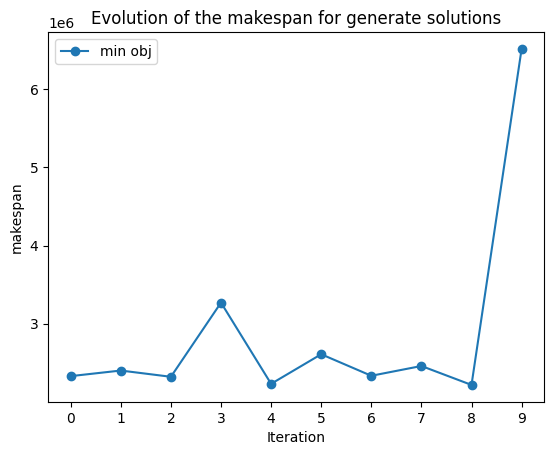

In [6]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[2328396, 2328396, 2319900, 2319900, 2229810, 2229810, 2229810, 2229810, 2215830, 2215830]


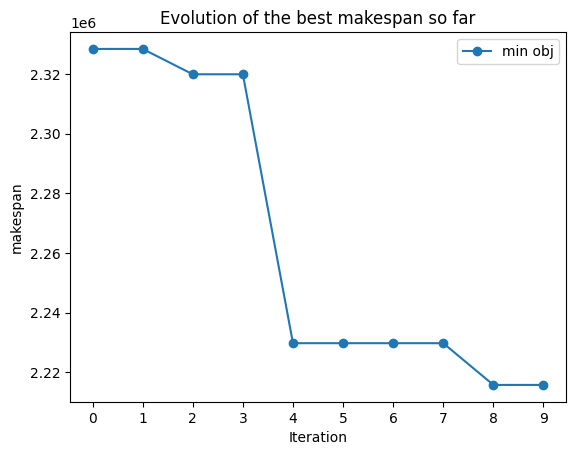

In [7]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

100


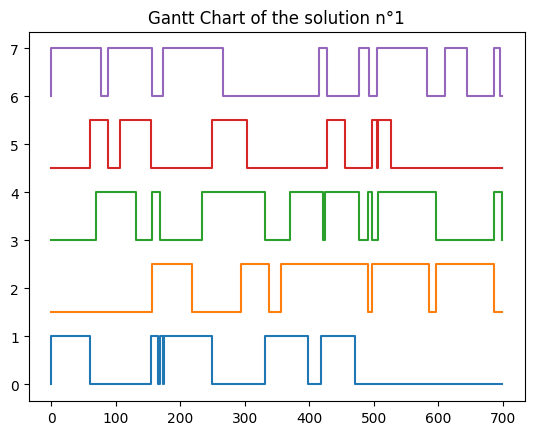

Makespan of the solution n°1 : 699
Regularity of the solution n°1 : 3170
Objective function of the solution n°1 : 2215830


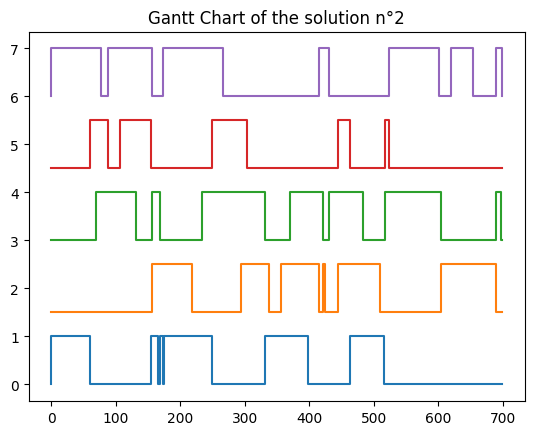

Makespan of the solution n°2 : 699
Regularity of the solution n°2 : 3190
Objective function of the solution n°2 : 2229810


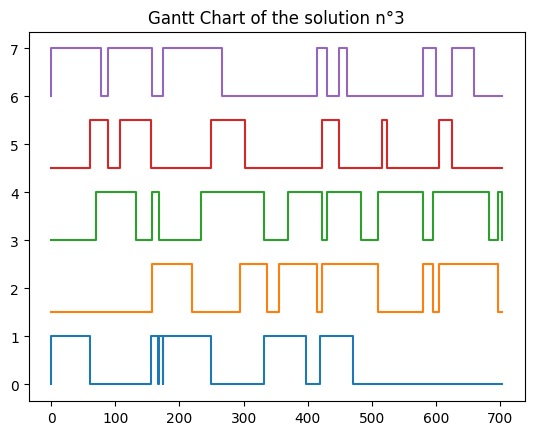

Makespan of the solution n°3 : 703
Regularity of the solution n°3 : 3300
Objective function of the solution n°3 : 2319900


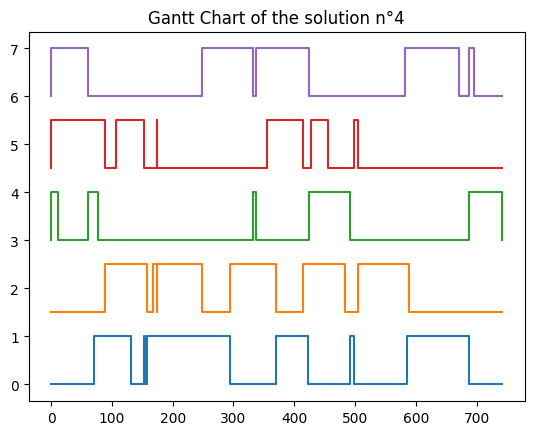

Makespan of the solution n°4 : 742
Regularity of the solution n°4 : 3138
Objective function of the solution n°4 : 2328396


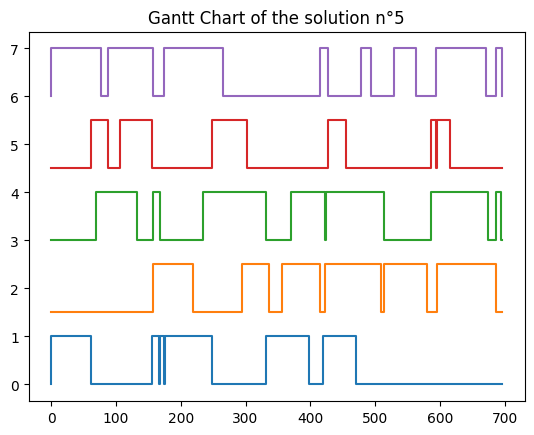

Makespan of the solution n°5 : 696
Regularity of the solution n°5 : 3352
Objective function of the solution n°5 : 2332992


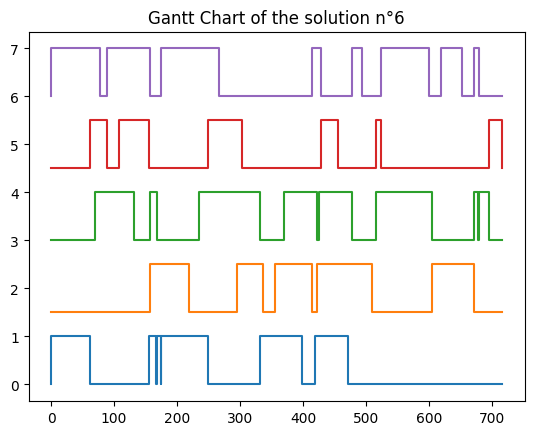

Makespan of the solution n°6 : 716
Regularity of the solution n°6 : 3352
Objective function of the solution n°6 : 2400032


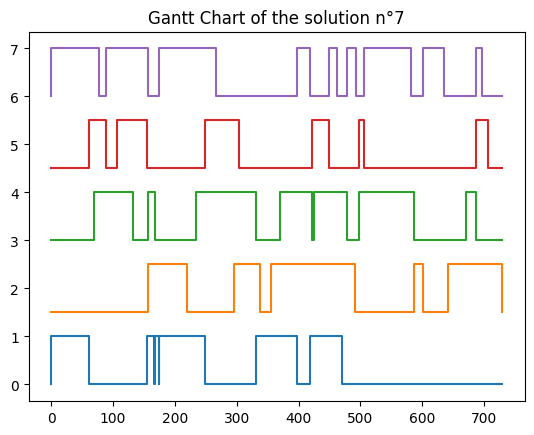

Makespan of the solution n°7 : 729
Regularity of the solution n°7 : 3372
Objective function of the solution n°7 : 2458188


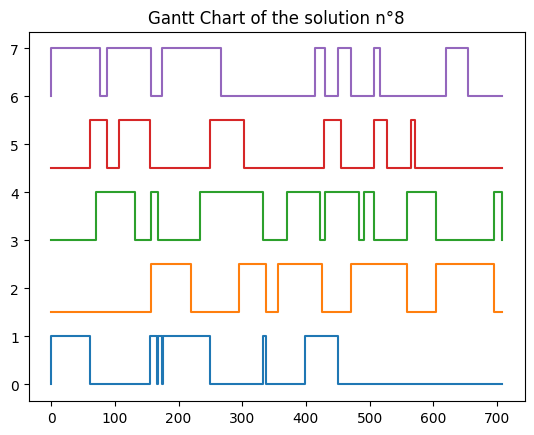

Makespan of the solution n°8 : 708
Regularity of the solution n°8 : 3478
Objective function of the solution n°8 : 2462424


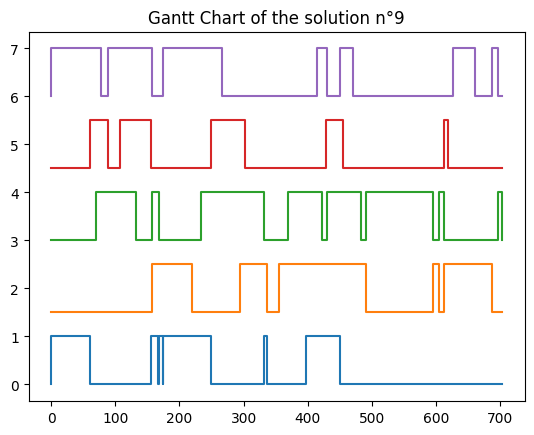

Makespan of the solution n°9 : 703
Regularity of the solution n°9 : 3616
Objective function of the solution n°9 : 2542048


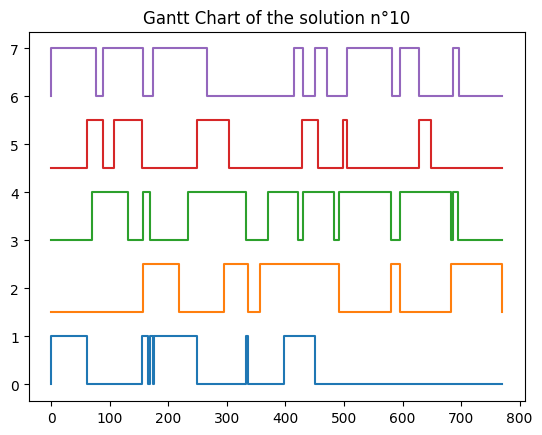

Makespan of the solution n°10 : 770
Regularity of the solution n°10 : 3348
Objective function of the solution n°10 : 2577960


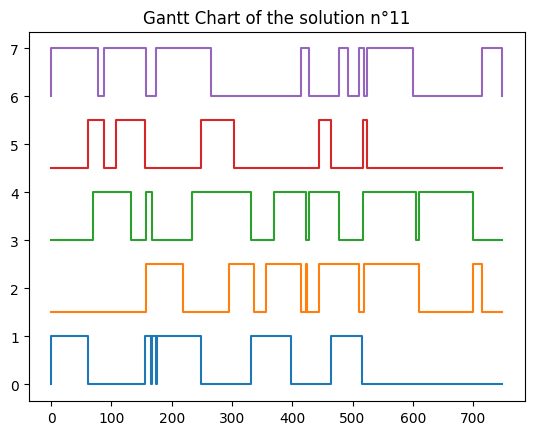

Makespan of the solution n°11 : 748
Regularity of the solution n°11 : 3456
Objective function of the solution n°11 : 2585088


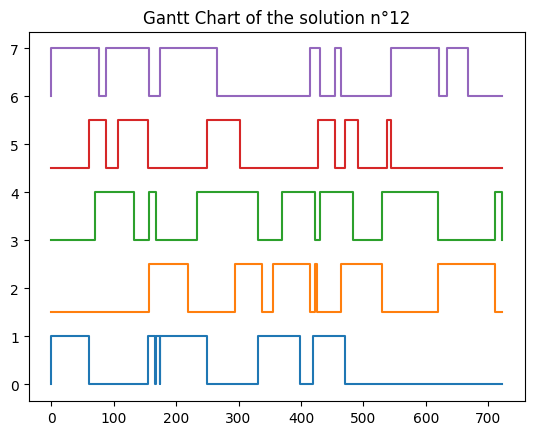

Makespan of the solution n°12 : 722
Regularity of the solution n°12 : 3590
Objective function of the solution n°12 : 2591980


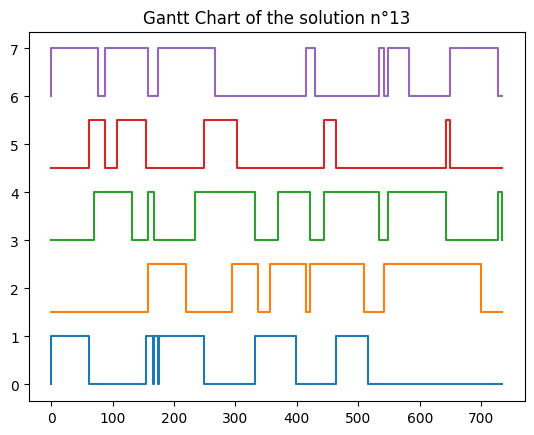

Makespan of the solution n°13 : 734
Regularity of the solution n°13 : 3554
Objective function of the solution n°13 : 2608636


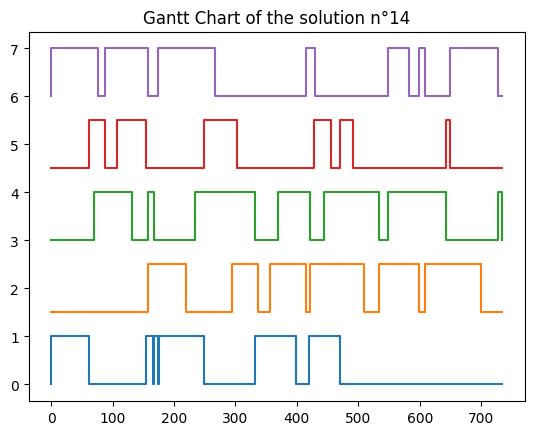

Makespan of the solution n°14 : 734
Regularity of the solution n°14 : 3554
Objective function of the solution n°14 : 2608636


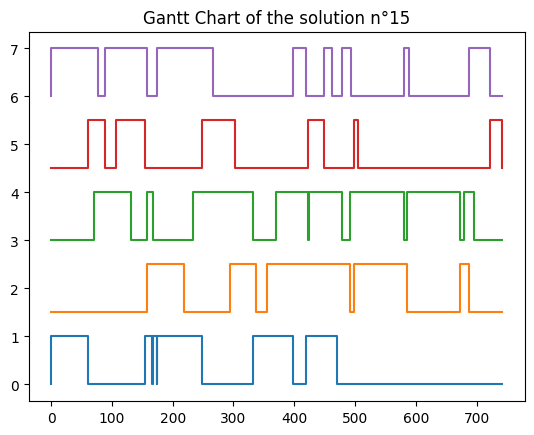

Makespan of the solution n°15 : 742
Regularity of the solution n°15 : 3516
Objective function of the solution n°15 : 2608872


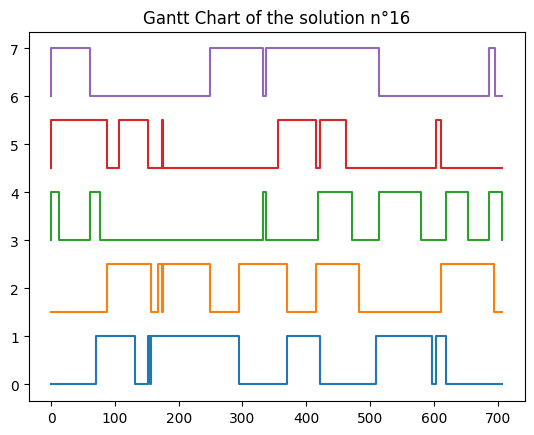

Makespan of the solution n°16 : 707
Regularity of the solution n°16 : 3722
Objective function of the solution n°16 : 2631454


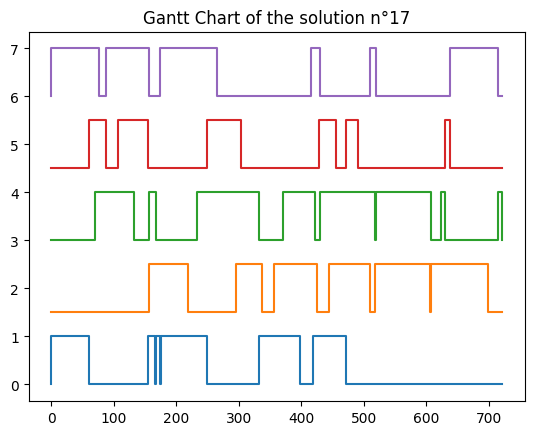

Makespan of the solution n°17 : 721
Regularity of the solution n°17 : 3750
Objective function of the solution n°17 : 2703750


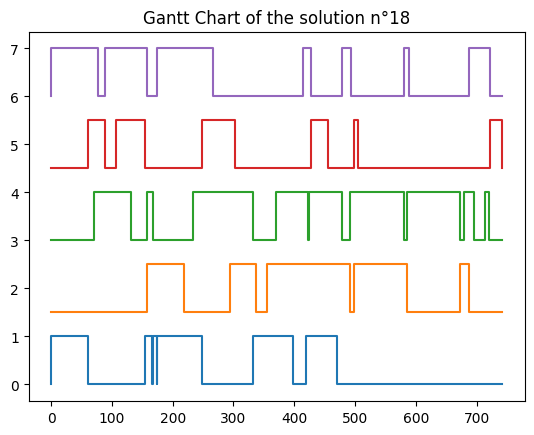

Makespan of the solution n°18 : 742
Regularity of the solution n°18 : 3666
Objective function of the solution n°18 : 2720172


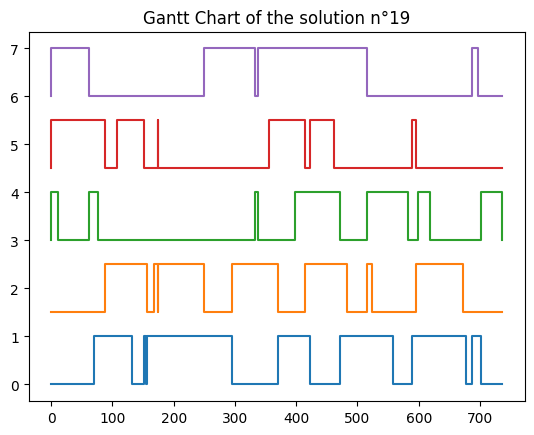

Makespan of the solution n°19 : 736
Regularity of the solution n°19 : 3738
Objective function of the solution n°19 : 2751168


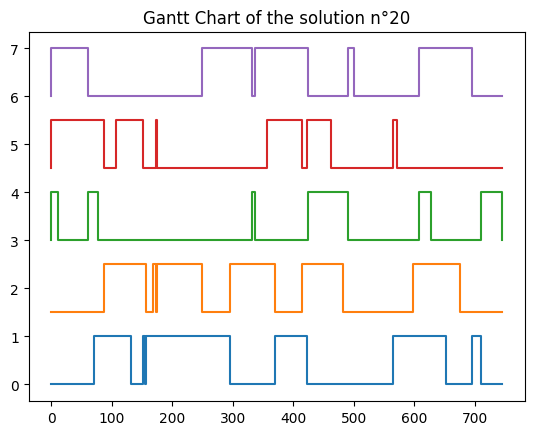

Makespan of the solution n°20 : 745
Regularity of the solution n°20 : 3722
Objective function of the solution n°20 : 2772890


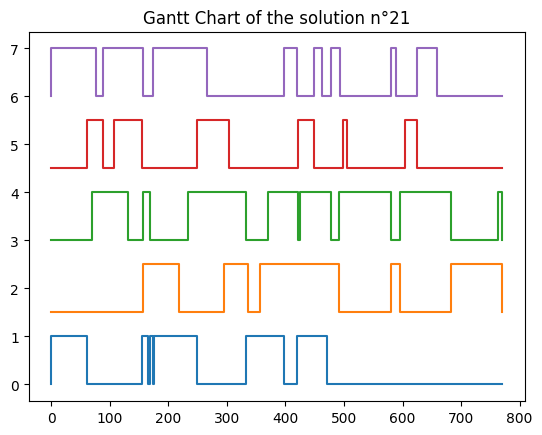

Makespan of the solution n°21 : 770
Regularity of the solution n°21 : 3678
Objective function of the solution n°21 : 2832060


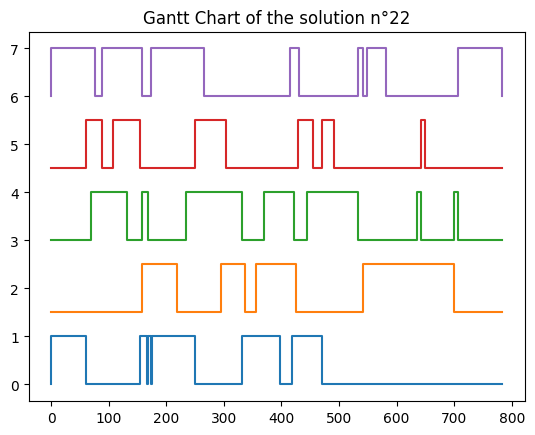

Makespan of the solution n°22 : 783
Regularity of the solution n°22 : 3746
Objective function of the solution n°22 : 2933118


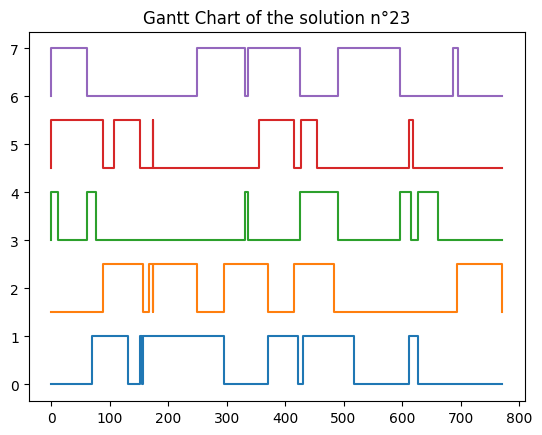

Makespan of the solution n°23 : 771
Regularity of the solution n°23 : 3888
Objective function of the solution n°23 : 2997648


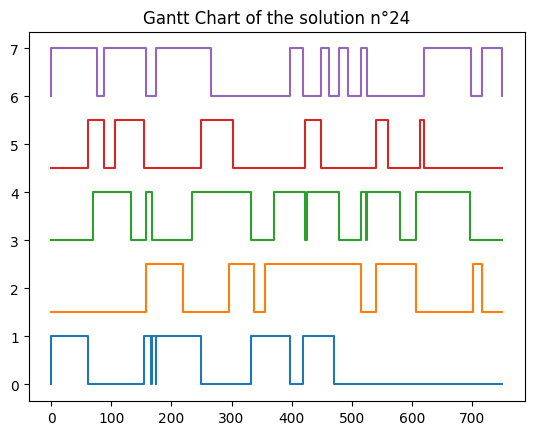

Makespan of the solution n°24 : 750
Regularity of the solution n°24 : 4066
Objective function of the solution n°24 : 3049500


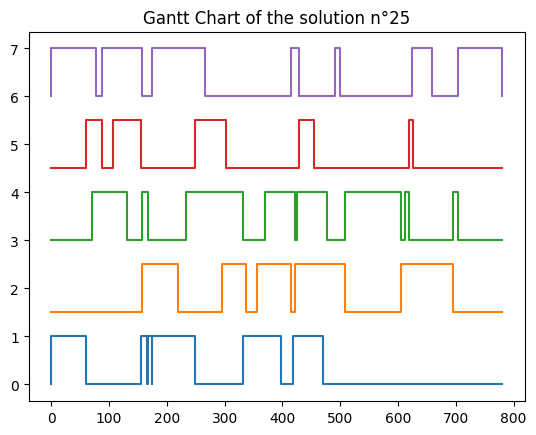

Makespan of the solution n°25 : 780
Regularity of the solution n°25 : 3944
Objective function of the solution n°25 : 3076320


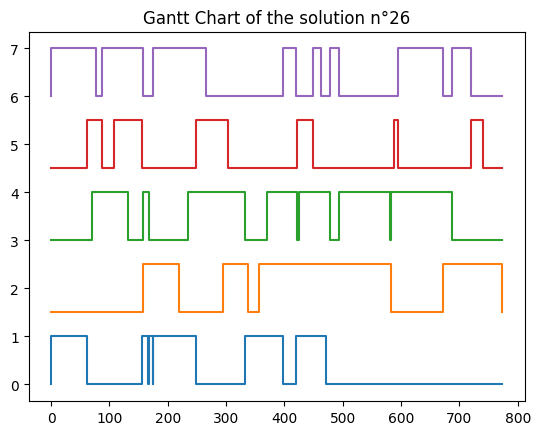

Makespan of the solution n°26 : 773
Regularity of the solution n°26 : 3982
Objective function of the solution n°26 : 3078086


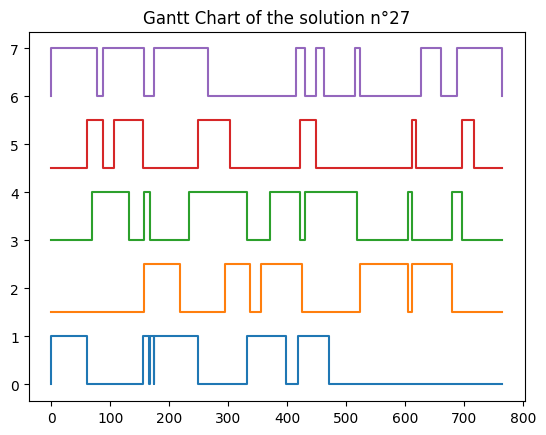

Makespan of the solution n°27 : 764
Regularity of the solution n°27 : 4066
Objective function of the solution n°27 : 3106424


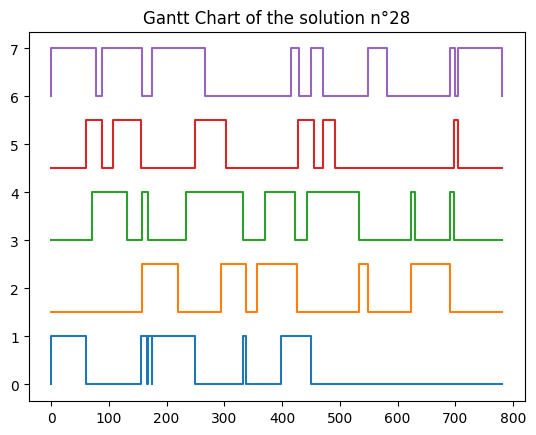

Makespan of the solution n°28 : 781
Regularity of the solution n°28 : 4018
Objective function of the solution n°28 : 3138058


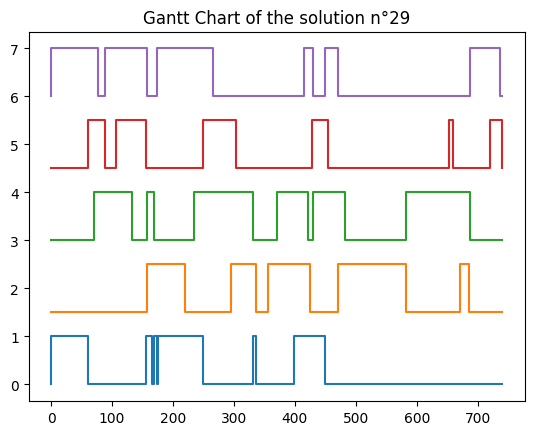

Makespan of the solution n°29 : 740
Regularity of the solution n°29 : 4280
Objective function of the solution n°29 : 3167200


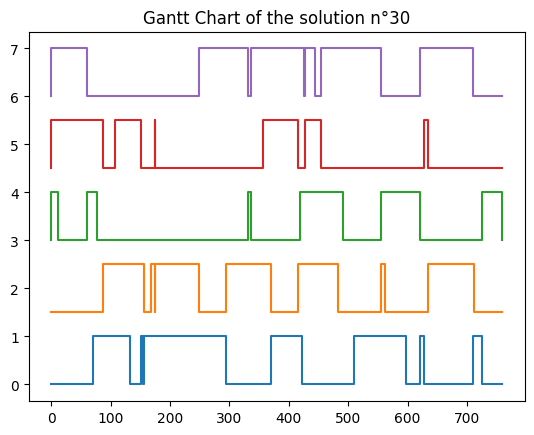

Makespan of the solution n°30 : 759
Regularity of the solution n°30 : 4298
Objective function of the solution n°30 : 3262182


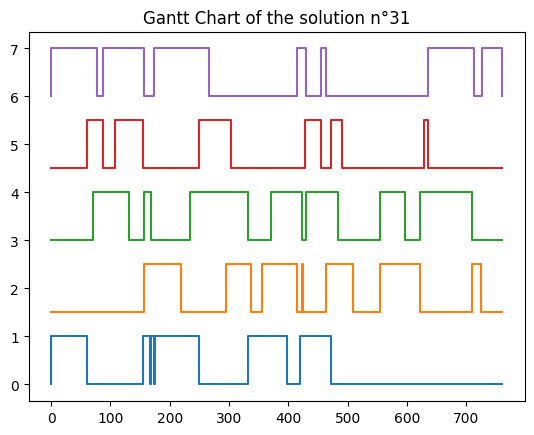

Makespan of the solution n°31 : 760
Regularity of the solution n°31 : 4302
Objective function of the solution n°31 : 3269520


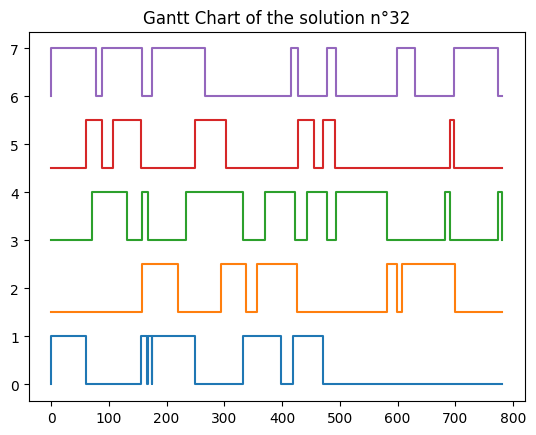

Makespan of the solution n°32 : 781
Regularity of the solution n°32 : 4240
Objective function of the solution n°32 : 3311440


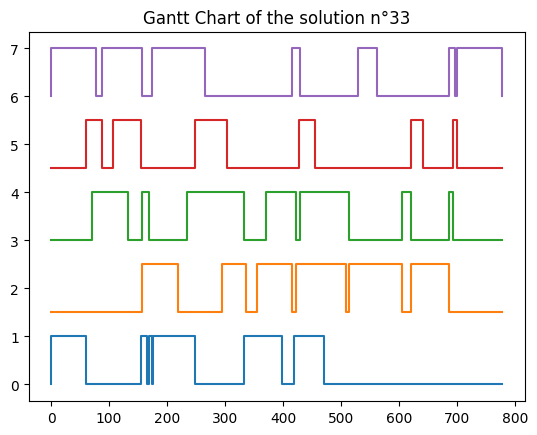

Makespan of the solution n°33 : 778
Regularity of the solution n°33 : 4278
Objective function of the solution n°33 : 3328284


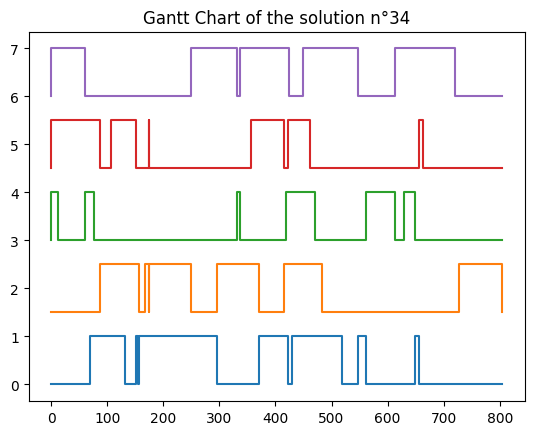

Makespan of the solution n°34 : 804
Regularity of the solution n°34 : 4190
Objective function of the solution n°34 : 3368760


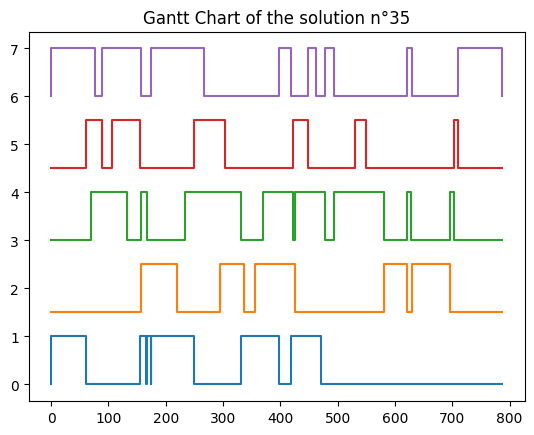

Makespan of the solution n°35 : 787
Regularity of the solution n°35 : 4296
Objective function of the solution n°35 : 3380952


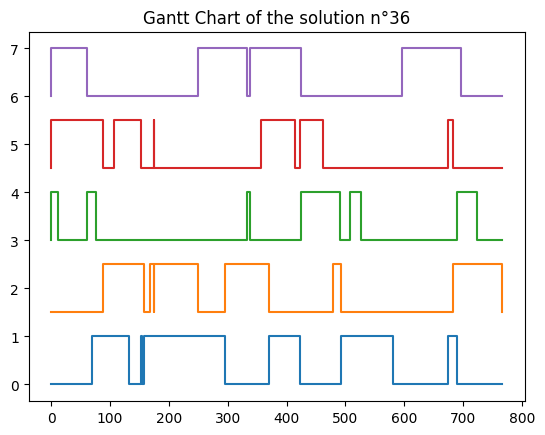

Makespan of the solution n°36 : 766
Regularity of the solution n°36 : 4476
Objective function of the solution n°36 : 3428616


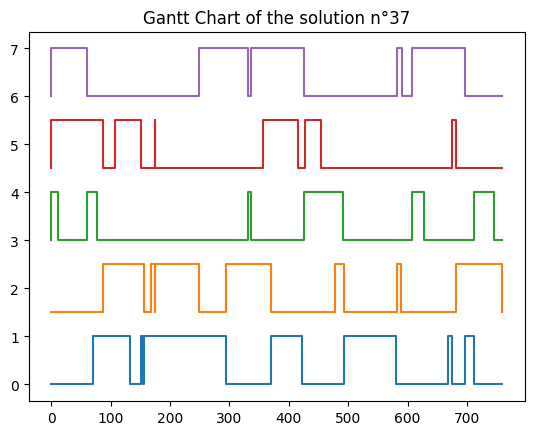

Makespan of the solution n°37 : 759
Regularity of the solution n°37 : 4546
Objective function of the solution n°37 : 3450414


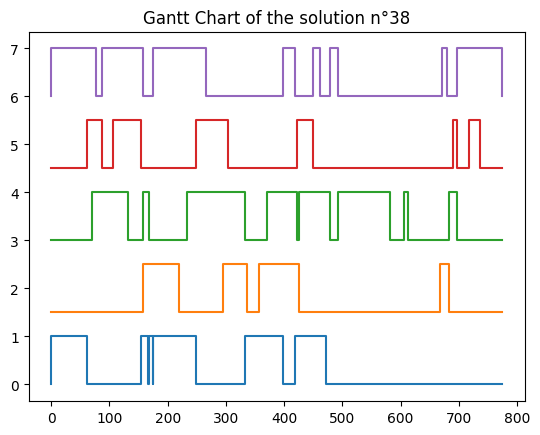

Makespan of the solution n°38 : 774
Regularity of the solution n°38 : 4620
Objective function of the solution n°38 : 3575880


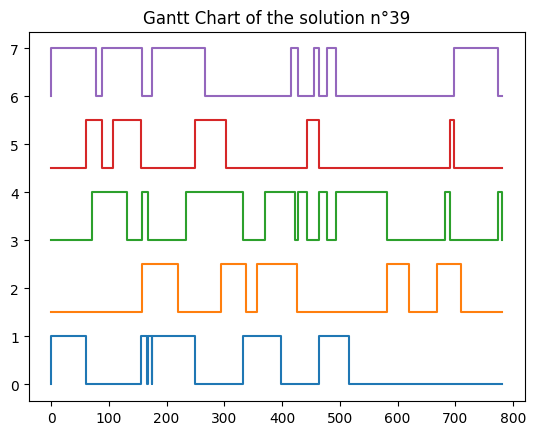

Makespan of the solution n°39 : 781
Regularity of the solution n°39 : 4610
Objective function of the solution n°39 : 3600410


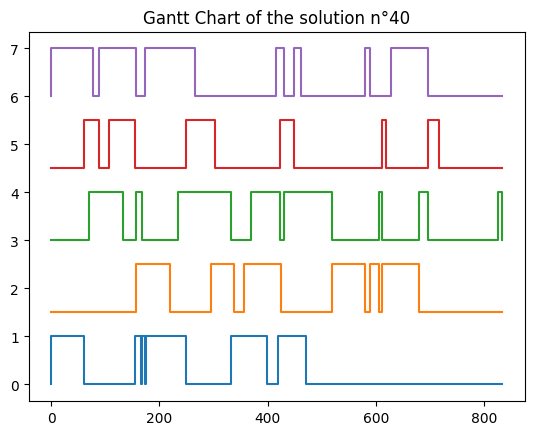

Makespan of the solution n°40 : 833
Regularity of the solution n°40 : 4342
Objective function of the solution n°40 : 3616886


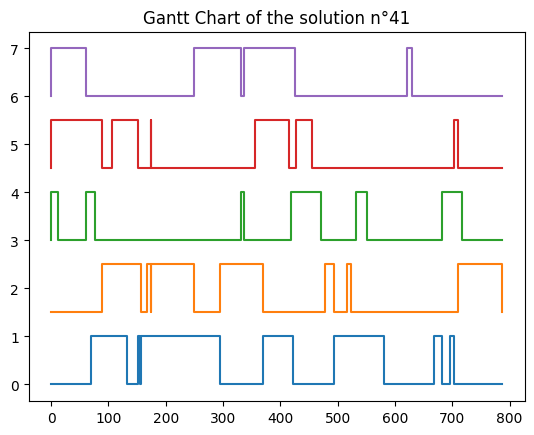

Makespan of the solution n°41 : 787
Regularity of the solution n°41 : 4658
Objective function of the solution n°41 : 3665846


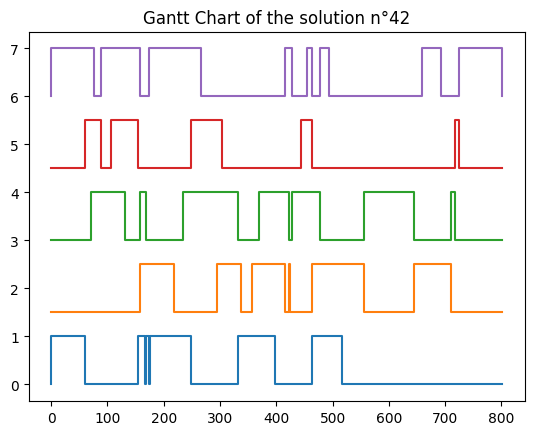

Makespan of the solution n°42 : 801
Regularity of the solution n°42 : 4680
Objective function of the solution n°42 : 3748680


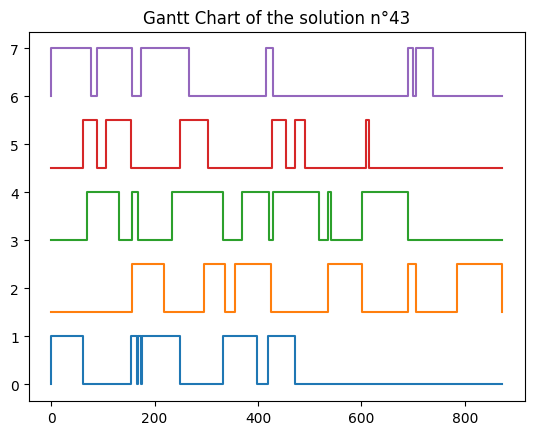

Makespan of the solution n°43 : 872
Regularity of the solution n°43 : 4356
Objective function of the solution n°43 : 3798432


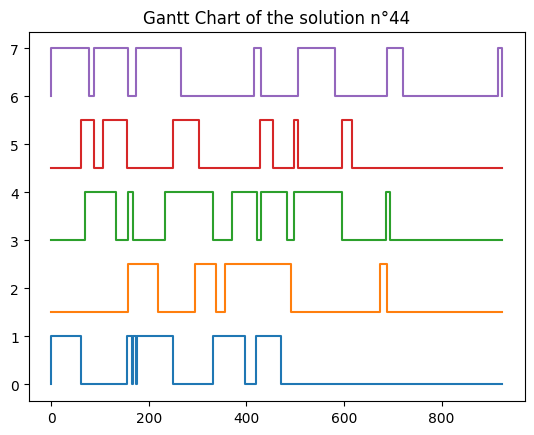

Makespan of the solution n°44 : 924
Regularity of the solution n°44 : 4194
Objective function of the solution n°44 : 3875256


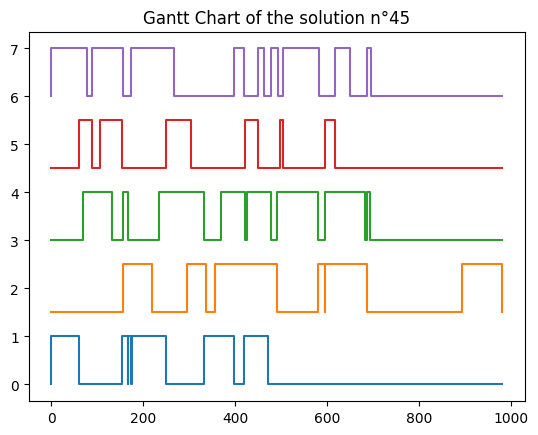

Makespan of the solution n°45 : 980
Regularity of the solution n°45 : 4012
Objective function of the solution n°45 : 3931760


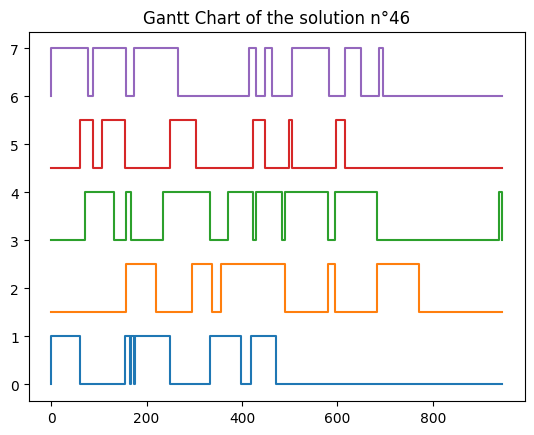

Makespan of the solution n°46 : 945
Regularity of the solution n°46 : 4342
Objective function of the solution n°46 : 4103190


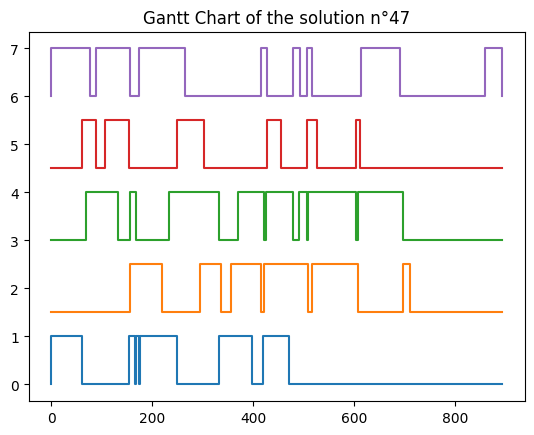

Makespan of the solution n°47 : 893
Regularity of the solution n°47 : 4666
Objective function of the solution n°47 : 4166738


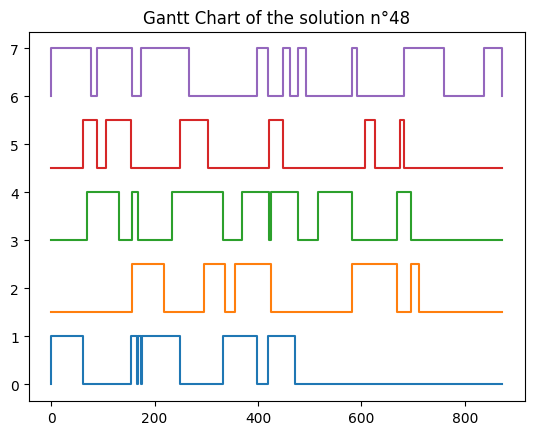

Makespan of the solution n°48 : 872
Regularity of the solution n°48 : 5040
Objective function of the solution n°48 : 4394880


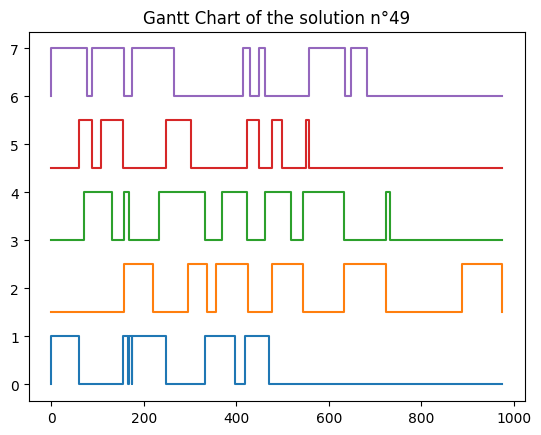

Makespan of the solution n°49 : 974
Regularity of the solution n°49 : 4564
Objective function of the solution n°49 : 4445336


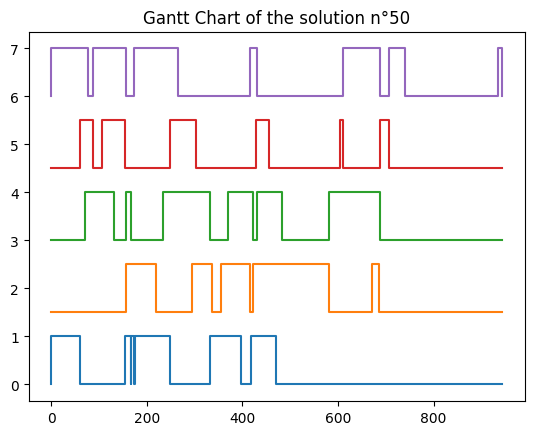

Makespan of the solution n°50 : 943
Regularity of the solution n°50 : 4738
Objective function of the solution n°50 : 4467934


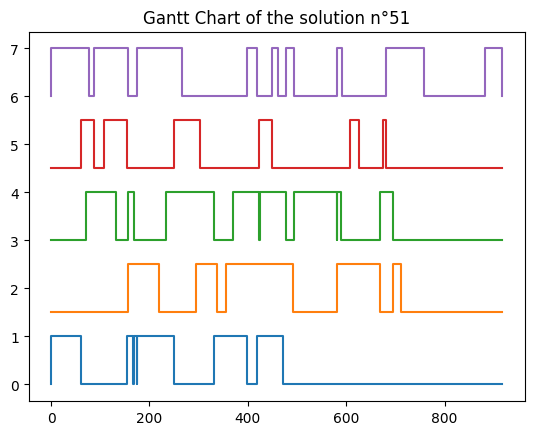

Makespan of the solution n°51 : 917
Regularity of the solution n°51 : 5220
Objective function of the solution n°51 : 4786740


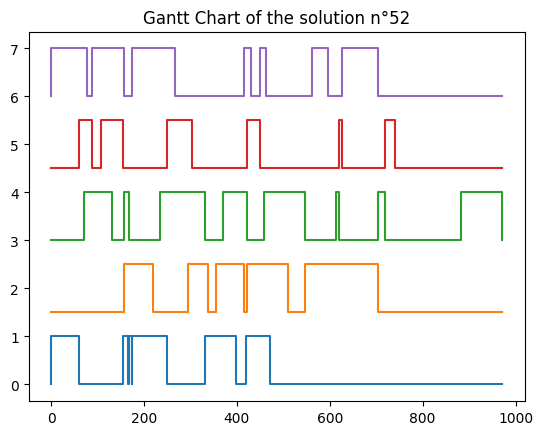

Makespan of the solution n°52 : 971
Regularity of the solution n°52 : 4994
Objective function of the solution n°52 : 4849174


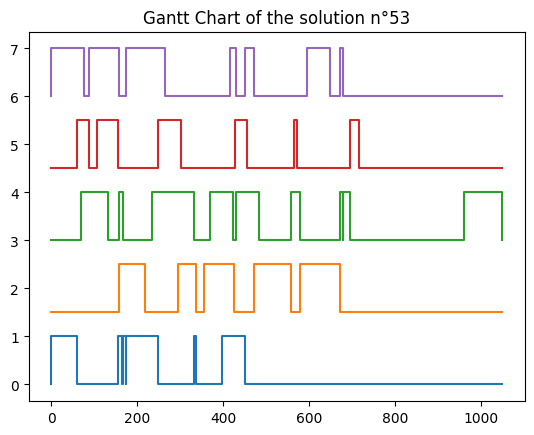

Makespan of the solution n°53 : 1049
Regularity of the solution n°53 : 4894
Objective function of the solution n°53 : 5133806


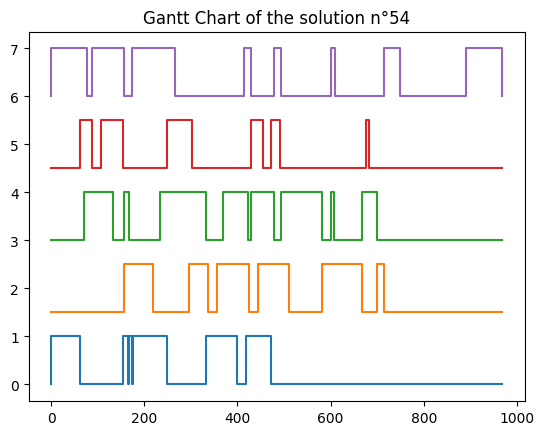

Makespan of the solution n°54 : 968
Regularity of the solution n°54 : 5400
Objective function of the solution n°54 : 5227200


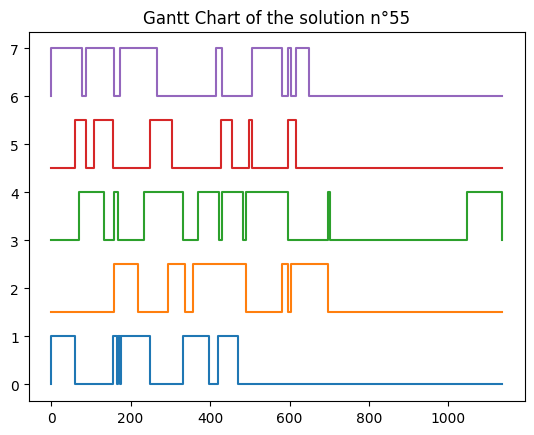

Makespan of the solution n°55 : 1135
Regularity of the solution n°55 : 4682
Objective function of the solution n°55 : 5314070


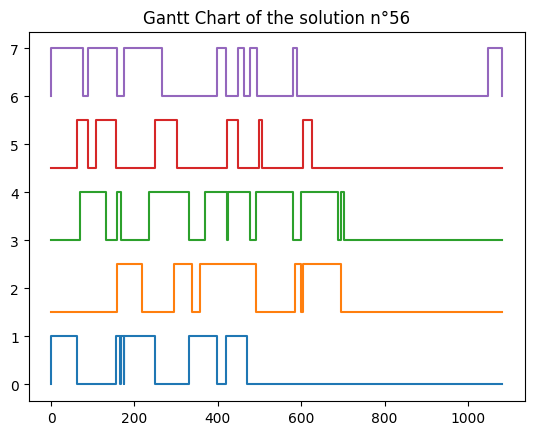

Makespan of the solution n°56 : 1082
Regularity of the solution n°56 : 4940
Objective function of the solution n°56 : 5345080


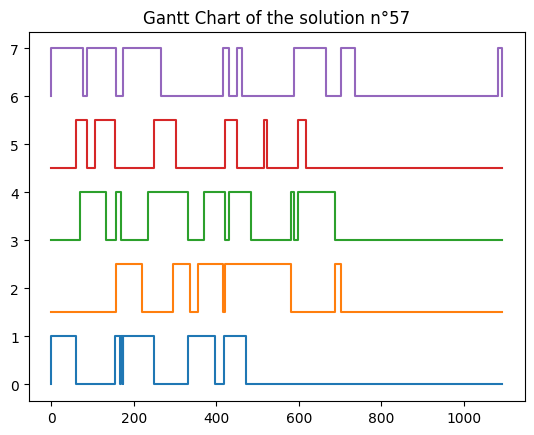

Makespan of the solution n°57 : 1092
Regularity of the solution n°57 : 4924
Objective function of the solution n°57 : 5377008


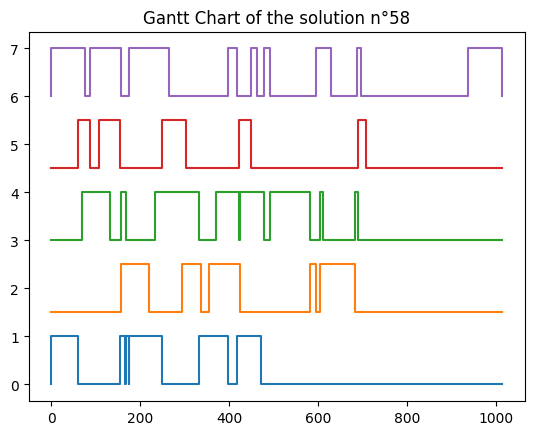

Makespan of the solution n°58 : 1014
Regularity of the solution n°58 : 5460
Objective function of the solution n°58 : 5536440


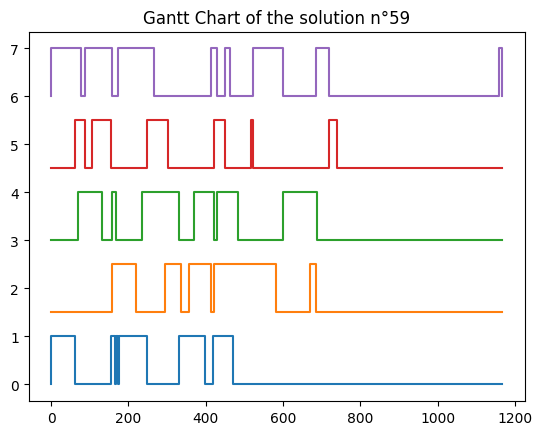

Makespan of the solution n°59 : 1167
Regularity of the solution n°59 : 4940
Objective function of the solution n°59 : 5764980


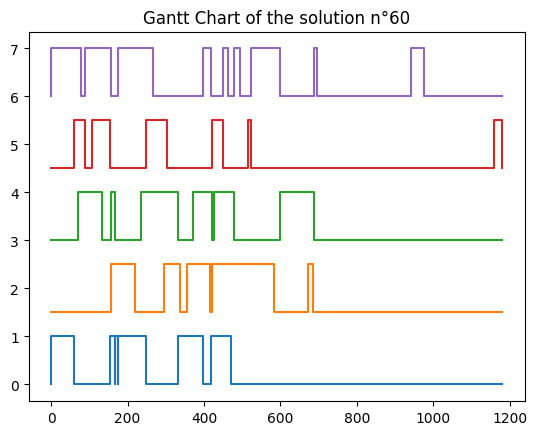

Makespan of the solution n°60 : 1180
Regularity of the solution n°60 : 5012
Objective function of the solution n°60 : 5914160


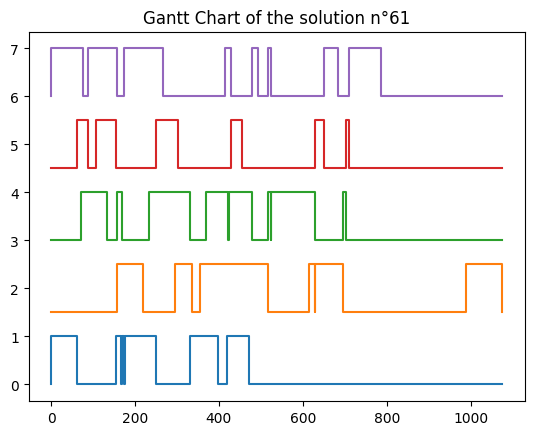

Makespan of the solution n°61 : 1075
Regularity of the solution n°61 : 5618
Objective function of the solution n°61 : 6039350


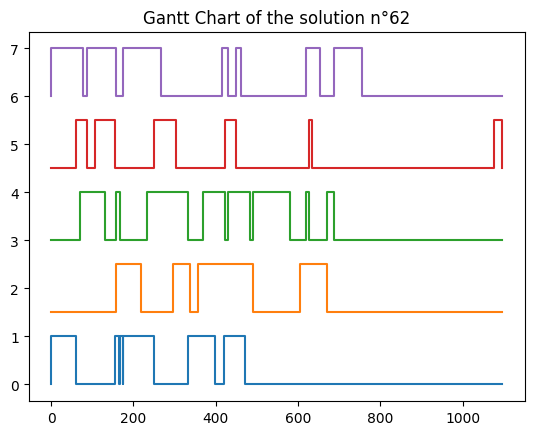

Makespan of the solution n°62 : 1096
Regularity of the solution n°62 : 5610
Objective function of the solution n°62 : 6148560


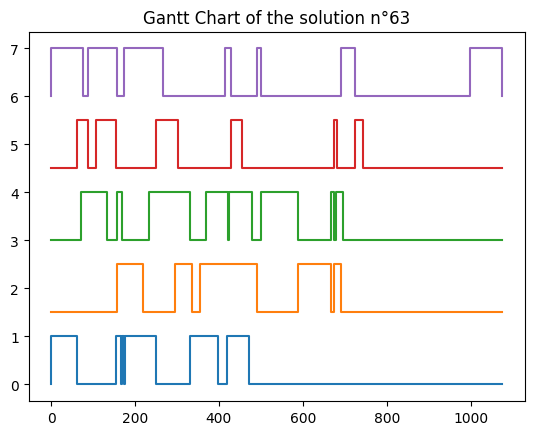

Makespan of the solution n°63 : 1075
Regularity of the solution n°63 : 5806
Objective function of the solution n°63 : 6241450


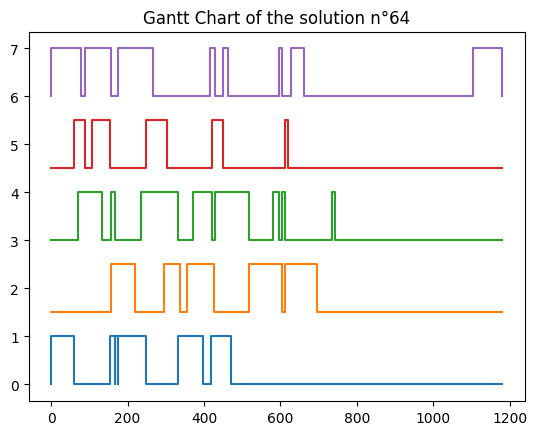

Makespan of the solution n°64 : 1180
Regularity of the solution n°64 : 5510
Objective function of the solution n°64 : 6501800


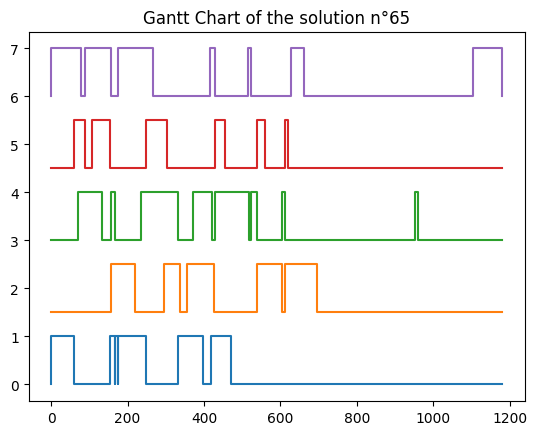

Makespan of the solution n°65 : 1180
Regularity of the solution n°65 : 5524
Objective function of the solution n°65 : 6518320


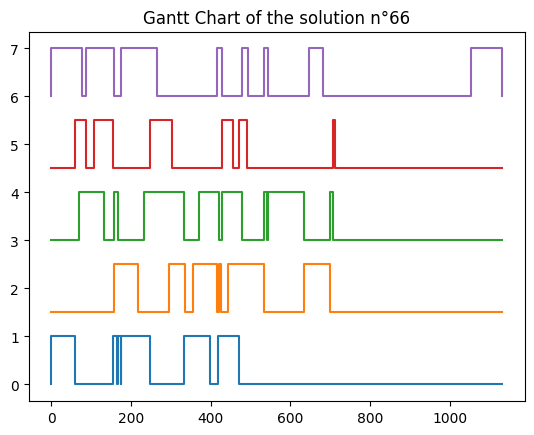

Makespan of the solution n°66 : 1131
Regularity of the solution n°66 : 5868
Objective function of the solution n°66 : 6636708


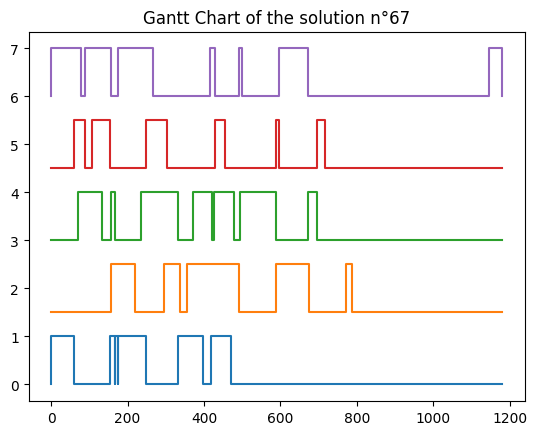

Makespan of the solution n°67 : 1180
Regularity of the solution n°67 : 5840
Objective function of the solution n°67 : 6891200


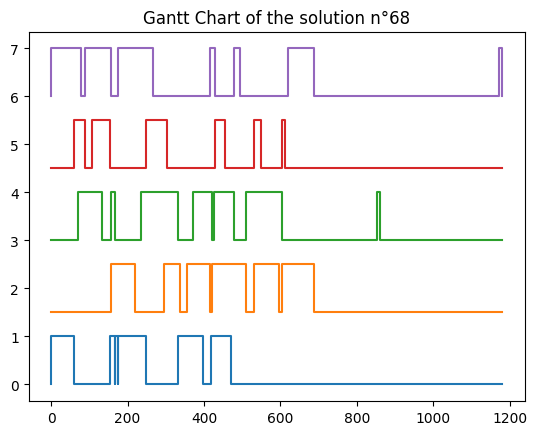

Makespan of the solution n°68 : 1180
Regularity of the solution n°68 : 5920
Objective function of the solution n°68 : 6985600


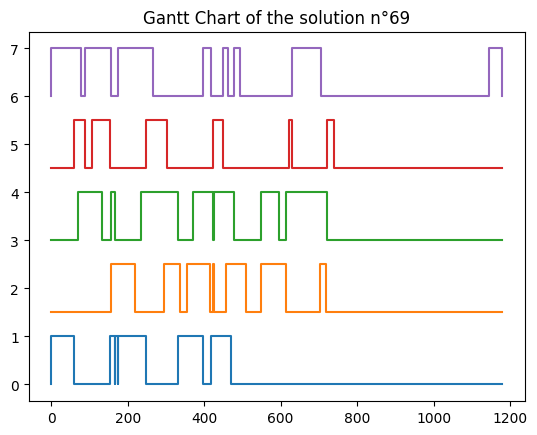

Makespan of the solution n°69 : 1179
Regularity of the solution n°69 : 5936
Objective function of the solution n°69 : 6998544


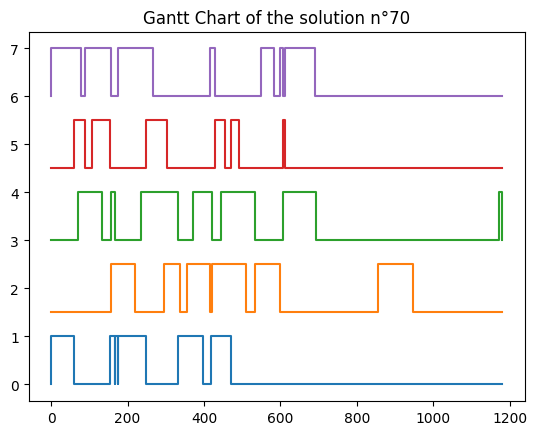

Makespan of the solution n°70 : 1180
Regularity of the solution n°70 : 6038
Objective function of the solution n°70 : 7124840


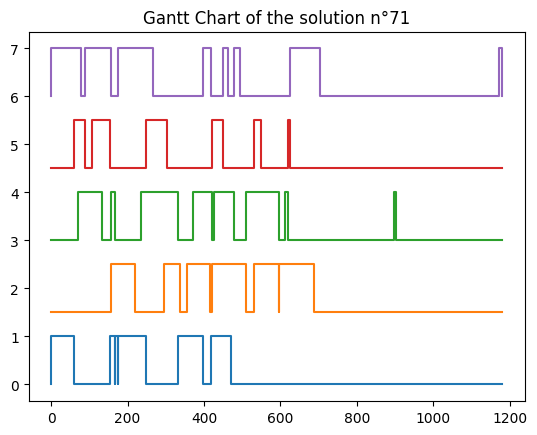

Makespan of the solution n°71 : 1180
Regularity of the solution n°71 : 6110
Objective function of the solution n°71 : 7209800


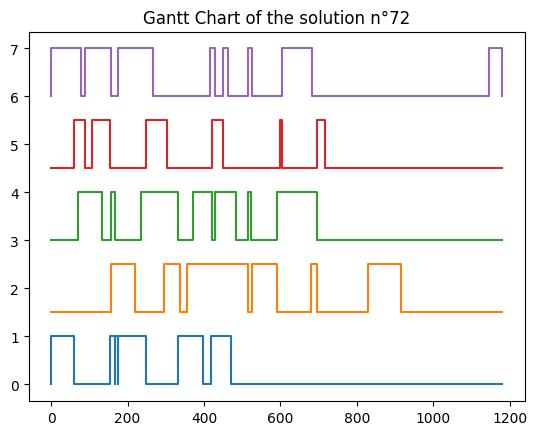

Makespan of the solution n°72 : 1180
Regularity of the solution n°72 : 6192
Objective function of the solution n°72 : 7306560


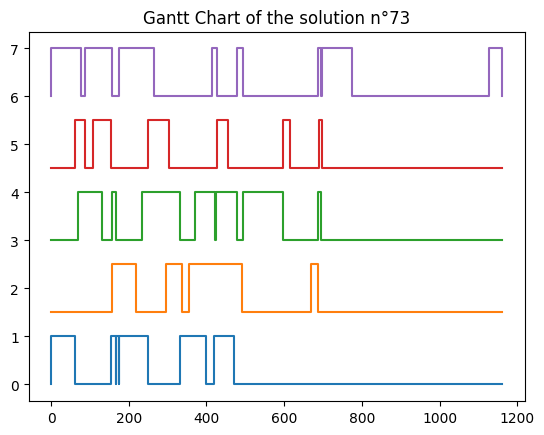

Makespan of the solution n°73 : 1161
Regularity of the solution n°73 : 6330
Objective function of the solution n°73 : 7349130


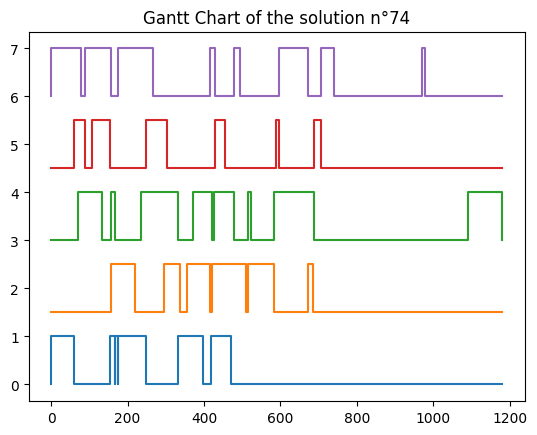

Makespan of the solution n°74 : 1180
Regularity of the solution n°74 : 6406
Objective function of the solution n°74 : 7559080


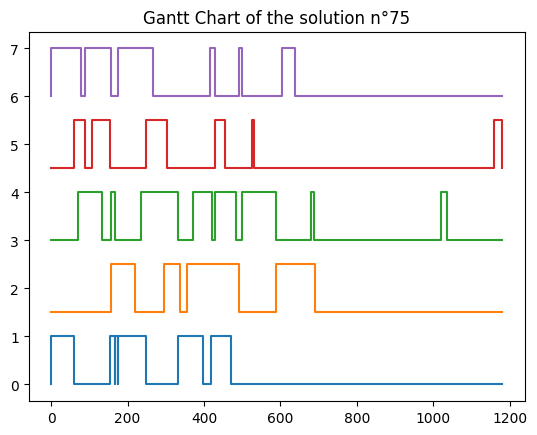

Makespan of the solution n°75 : 1180
Regularity of the solution n°75 : 6534
Objective function of the solution n°75 : 7710120


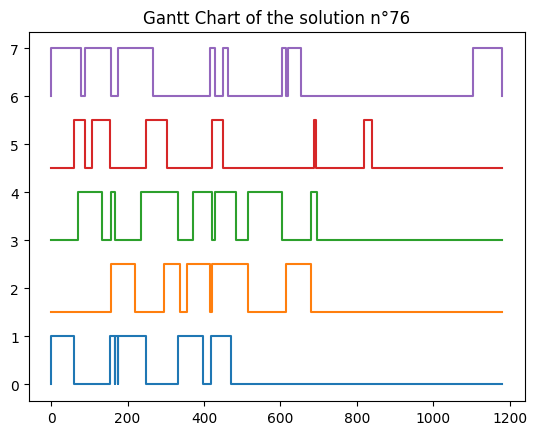

Makespan of the solution n°76 : 1180
Regularity of the solution n°76 : 6596
Objective function of the solution n°76 : 7783280


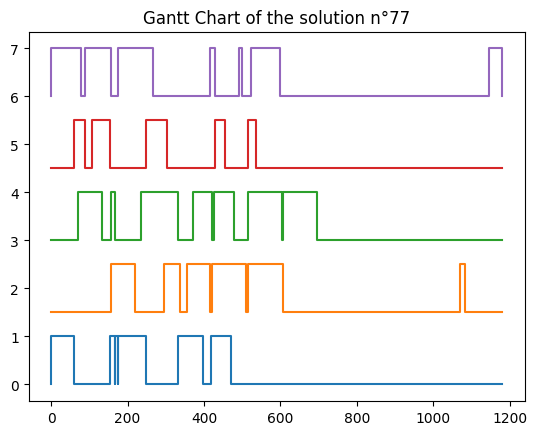

Makespan of the solution n°77 : 1180
Regularity of the solution n°77 : 6646
Objective function of the solution n°77 : 7842280


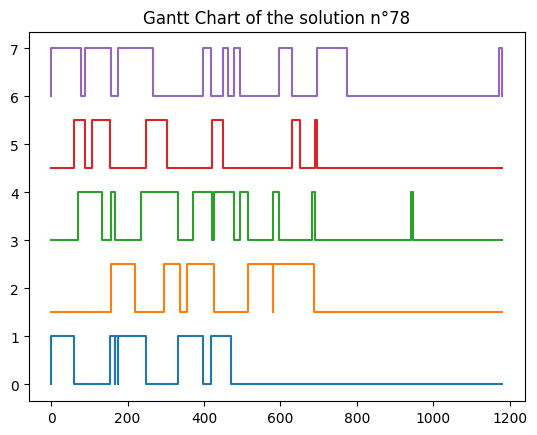

Makespan of the solution n°78 : 1180
Regularity of the solution n°78 : 6708
Objective function of the solution n°78 : 7915440


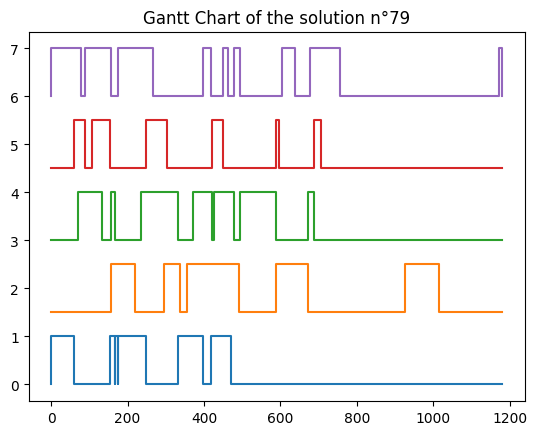

Makespan of the solution n°79 : 1180
Regularity of the solution n°79 : 6886
Objective function of the solution n°79 : 8125480


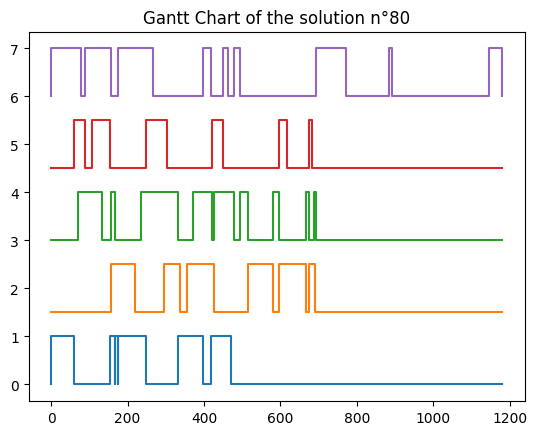

Makespan of the solution n°80 : 1180
Regularity of the solution n°80 : 6908
Objective function of the solution n°80 : 8151440


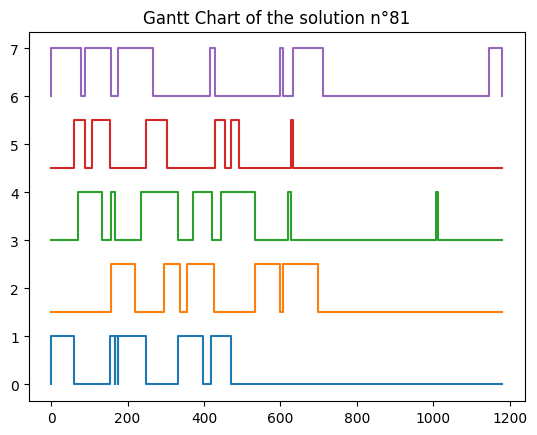

Makespan of the solution n°81 : 1180
Regularity of the solution n°81 : 6998
Objective function of the solution n°81 : 8257640


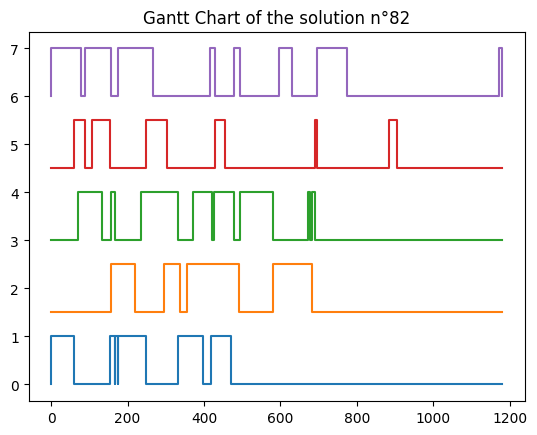

Makespan of the solution n°82 : 1180
Regularity of the solution n°82 : 7042
Objective function of the solution n°82 : 8309560


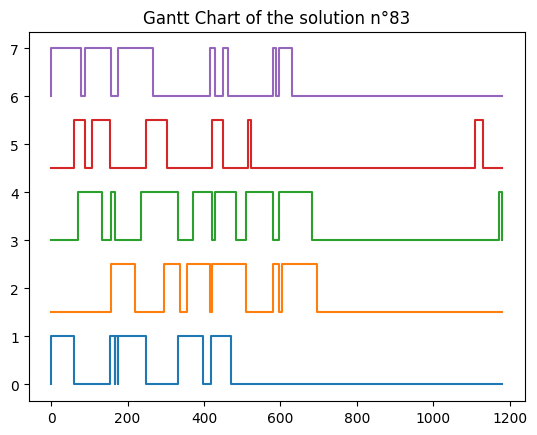

Makespan of the solution n°83 : 1180
Regularity of the solution n°83 : 7092
Objective function of the solution n°83 : 8368560


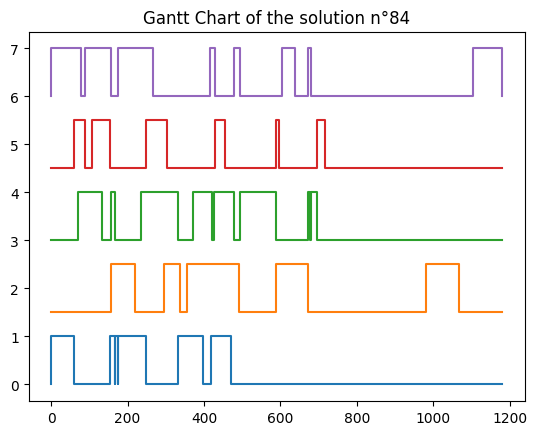

Makespan of the solution n°84 : 1180
Regularity of the solution n°84 : 7108
Objective function of the solution n°84 : 8387440


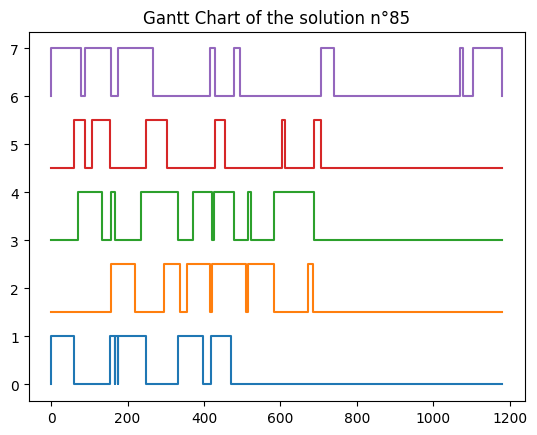

Makespan of the solution n°85 : 1180
Regularity of the solution n°85 : 7250
Objective function of the solution n°85 : 8555000


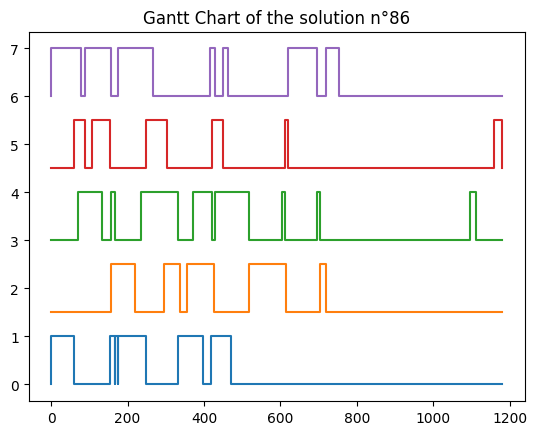

Makespan of the solution n°86 : 1180
Regularity of the solution n°86 : 7300
Objective function of the solution n°86 : 8614000


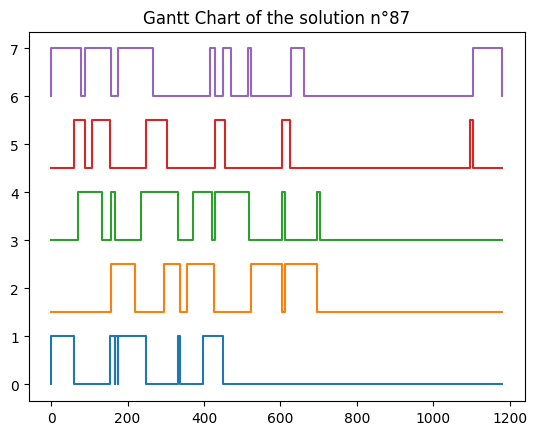

Makespan of the solution n°87 : 1180
Regularity of the solution n°87 : 7460
Objective function of the solution n°87 : 8802800


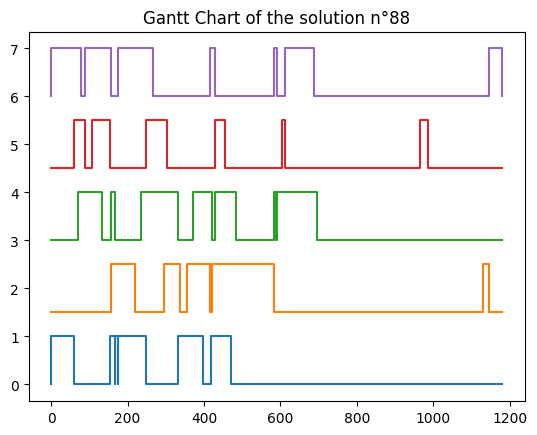

Makespan of the solution n°88 : 1180
Regularity of the solution n°88 : 7542
Objective function of the solution n°88 : 8899560


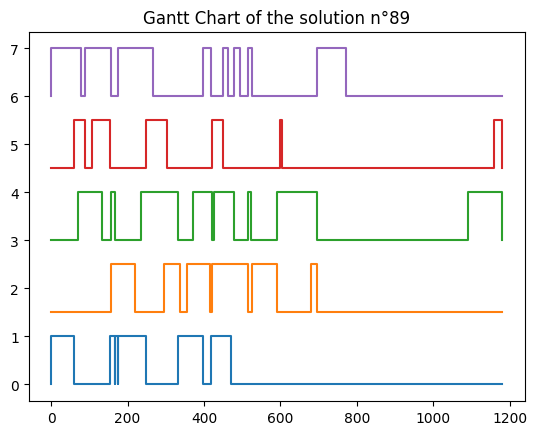

Makespan of the solution n°89 : 1180
Regularity of the solution n°89 : 7644
Objective function of the solution n°89 : 9019920


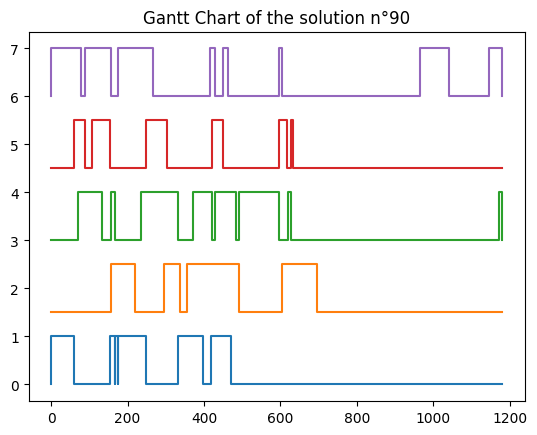

Makespan of the solution n°90 : 1180
Regularity of the solution n°90 : 7646
Objective function of the solution n°90 : 9022280


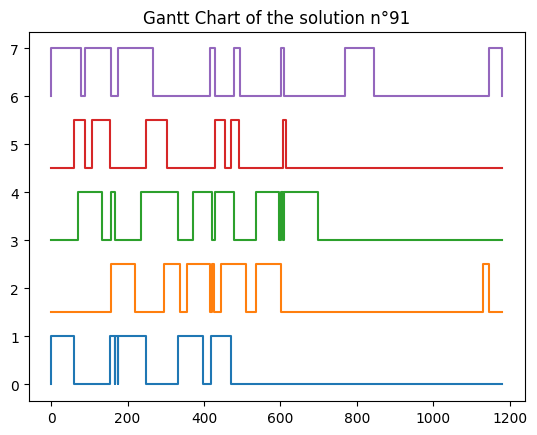

Makespan of the solution n°91 : 1180
Regularity of the solution n°91 : 8176
Objective function of the solution n°91 : 9647680


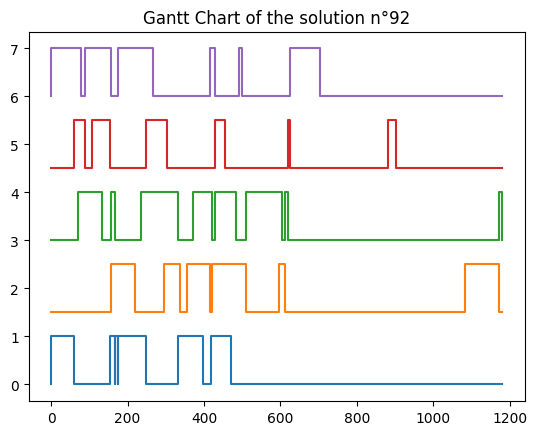

Makespan of the solution n°92 : 1180
Regularity of the solution n°92 : 8228
Objective function of the solution n°92 : 9709040


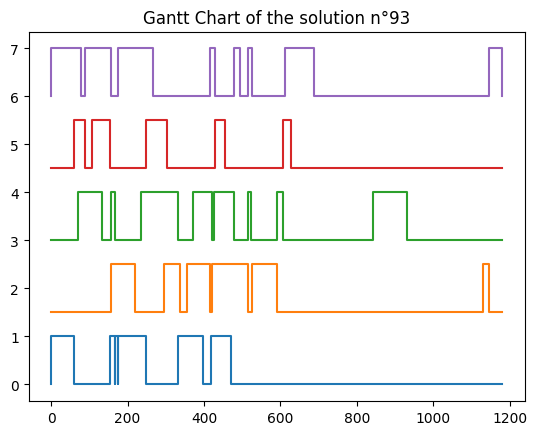

Makespan of the solution n°93 : 1180
Regularity of the solution n°93 : 8282
Objective function of the solution n°93 : 9772760


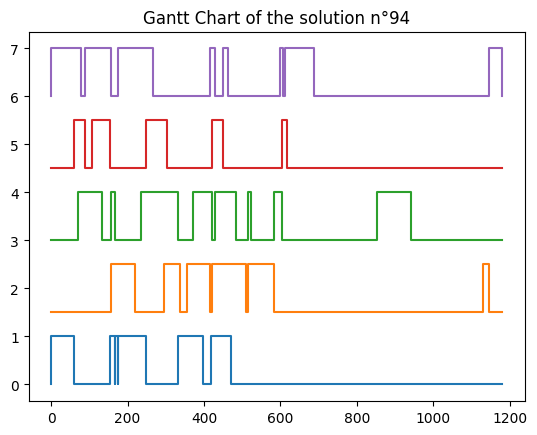

Makespan of the solution n°94 : 1180
Regularity of the solution n°94 : 8320
Objective function of the solution n°94 : 9817600


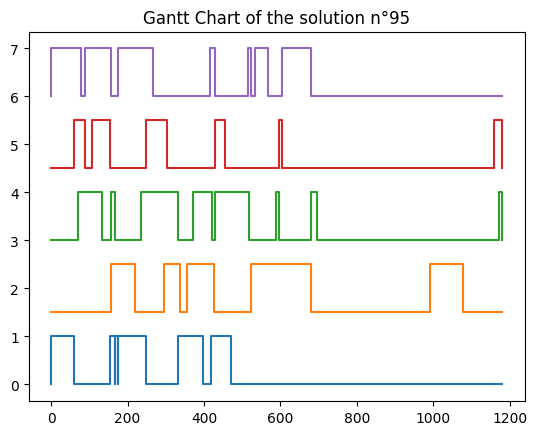

Makespan of the solution n°95 : 1180
Regularity of the solution n°95 : 9016
Objective function of the solution n°95 : 10638880


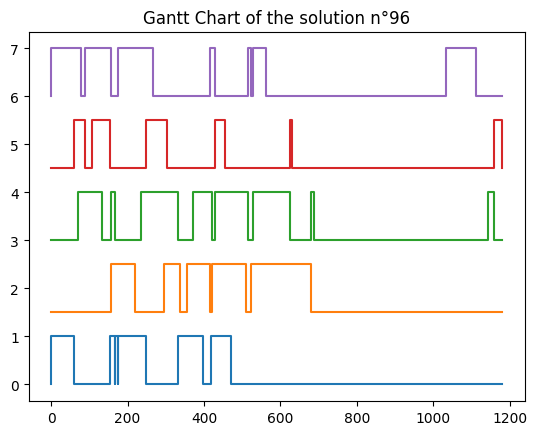

Makespan of the solution n°96 : 1180
Regularity of the solution n°96 : 9032
Objective function of the solution n°96 : 10657760


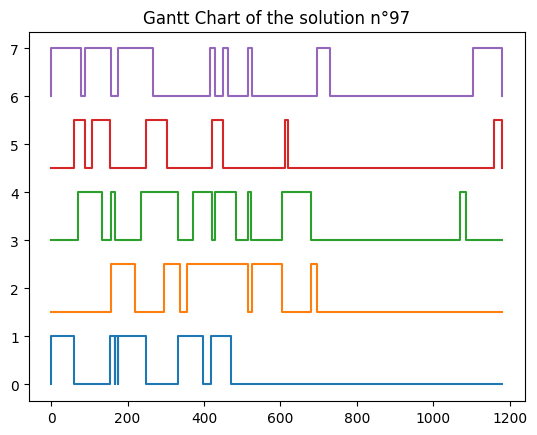

Makespan of the solution n°97 : 1180
Regularity of the solution n°97 : 9056
Objective function of the solution n°97 : 10686080


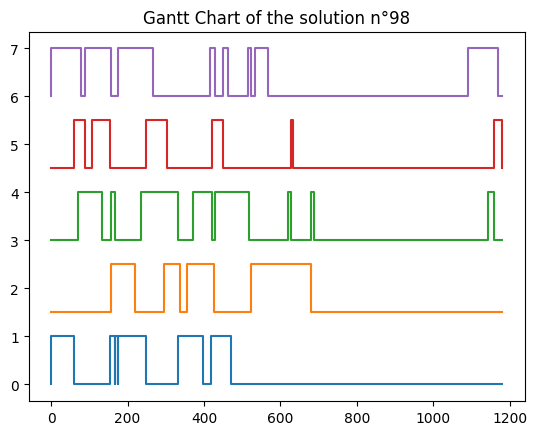

Makespan of the solution n°98 : 1180
Regularity of the solution n°98 : 9262
Objective function of the solution n°98 : 10929160


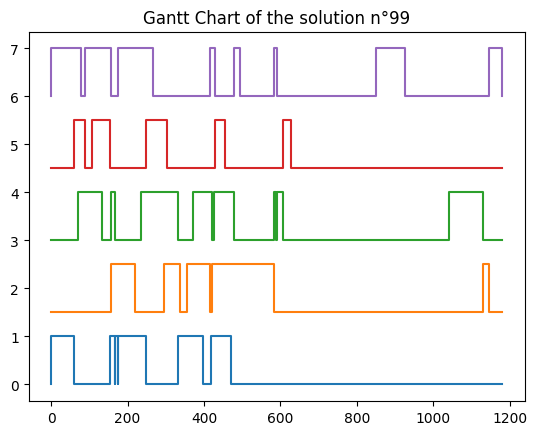

Makespan of the solution n°99 : 1180
Regularity of the solution n°99 : 10042
Objective function of the solution n°99 : 11849560


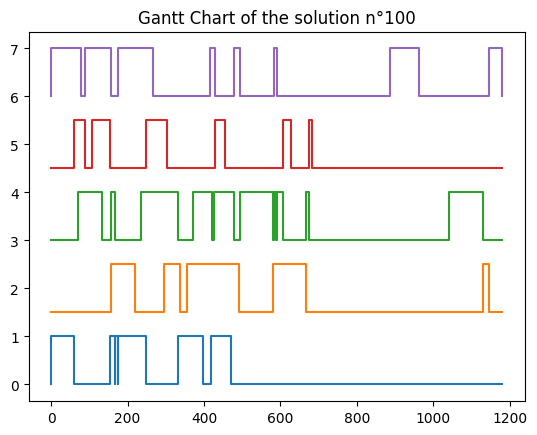

Makespan of the solution n°100 : 1180
Regularity of the solution n°100 : 10304
Objective function of the solution n°100 : 12158720


In [9]:
pref = user.getPreferences()
print(len(pref))

# ------------ Generate Gantt Chart
start_times = []
end_times = []
task_lengths = []

n_sol = 0
for sol in pref:
    n_sol = n_sol + 1
    sol_list = sol.get_all_var_solutions()
    
    mkspan=max([sol_list[i].get_end() for i in range(len(sol_list))] )
    x = [ [] for i in range(m)]
    y = [ [] for i in range(m)]
    mp = [ {} for i in range(m)]
    sz=len(sol_list)
    for i in range(sz) : 
        ind=T_machine[i]
        x[ind].append(sol_list[i].get_start())
        mp[ind][sol_list[i].get_start()]=ind
        x[ind].append(sol_list[i].get_end())
        mp[ind][sol_list[i].get_end()]=ind+1
    eps=0.5
    for i in range(m):
        x[i]=sorted(x[i])
        y[i]=[mp[i][x[i][j]]+i*eps for j in range(len(x[i]))]
        x[i]=[0]+x[i]
        y[i]=[i+i*eps]+y[i]
        x[i]=x[i]+[mkspan]
        y[i].append(i+i*eps)
        plt.step(x[i],y[i])
    plt.title("Gantt Chart of the solution n°" + str(n_sol))
    plt.show()
    print("Makespan of the solution n°" + str(n_sol) + " : " + str(mkspan))
    print("Regularity of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunctionRegularity(sol, n, m)))
    print("Objective function of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m)))